In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score,precision_score,recall_score,f1_score
from imblearn.over_sampling import SMOTE
import pickle
from datetime import datetime
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = '../Data/fraudTrain.csv'
df = pd.read_csv(data_path)
df.shape

(1296675, 23)

In [4]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [5]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [6]:
df['is_fraud'].value_counts(normalize=True)

is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

we have imbalance target variable.

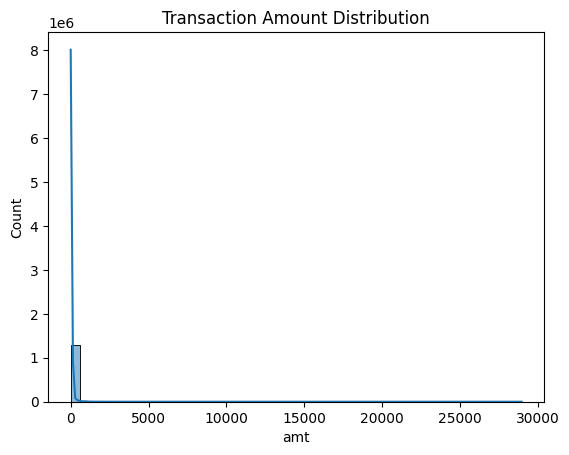

In [7]:
sns.histplot(df['amt'],bins=50, kde=True)
plt.title('Transaction Amount Distribution')
plt.show()

In [8]:
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['age'] = (pd.to_datetime('today')- df['dob']).dt.days//365

In [9]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], errors='coerce')
df['hour'] = df['trans_date_trans_time'].dt.hour
df['day'] = df['trans_date_trans_time'].dt.day
df['weekday'] = df['trans_date_trans_time'].dt.weekday


Computing distance between user and merchant:

In [ ]:
def compute_distance(row):
    try:
        return geodesic((row['lat'], row['long']), (row['merch_lat'], row['merch_long'])).km
    except:
        return np.nan
    
df['distance'] = df.apply(compute_distance, axis=1)


### Select Features

* Unnamed: 0, cc_num, first, last, street, trans_num are unique per transaction or per person, so including them would cause data leakage
* lat, long, merch_lat, merch_long can not used directly so we create new feature called 'distance' which is good fraud indicator.
* Other features can be used for training.

In [ ]:
feature_cols = ['amt', 'merchant', 'category', 'gender', 'city', 'state', 'job',
                'age', 'hour', 'day', 'weekday', 'distance']


X = df[feature_cols]
y = df['is_fraud']

In [ ]:
categorical_cols = X.select_dtypes('object').columns.tolist()
numeric_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

for col in categorical_cols:
    X[col] = X[col].fillna(X[col].mode()[0])  
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [ ]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight= (len(y_train_res) - sum(y_train_res)) / sum(y_train_res),  # handle imbalance
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


              precision    recall  f1-score   support

           0       1.00      0.98      0.99    257834
           1       0.18      0.89      0.30      1501

    accuracy                           0.98    259335
   macro avg       0.59      0.93      0.64    259335
weighted avg       0.99      0.98      0.98    259335

ROC-AUC Score: 0.977229521070829


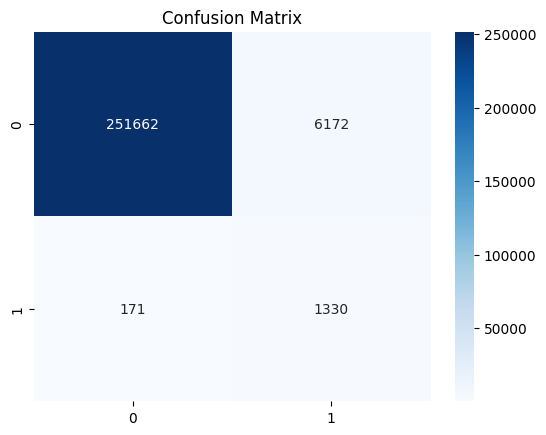

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

### hyper parameter tuning

In [ ]:

# Hyperparameter grid for tuning
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# Randomized search
rs = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=10,
                        scoring='f1', cv=3, verbose=1, n_jobs=-1, random_state=42)
rs.fit(X_train_res, y_train_res)

# Best estimator
best_xgb = rs.best_estimator_
print("Best Parameters:", rs.best_params_)

# Predict probabilities
y_proba = best_xgb.predict_proba(X_test)[:,1]

# Tune threshold for best F1-score
thresholds = np.arange(0.1, 0.9, 0.01)
best_f1 = 0
best_thresh = 0.5

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"Optimal threshold: {best_thresh}, F1-score: {best_f1:.4f}")

# Final predictions using optimal threshold
y_pred_final = (y_proba >= best_thresh).astype(int)

# Evaluation
print(classification_report(y_test, y_pred_final))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Optimal threshold: 0.8899999999999996, F1-score: 0.7854
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.80      0.77      0.79      1501

    accuracy                           1.00    259335
   macro avg       0.90      0.88      0.89    259335
weighted avg       1.00      1.00      1.00    259335

ROC-AUC: 0.9837763199482934


In [ ]:
model_save_path = '../models/fraud_model.pkl'

with open(model_save_path, 'wb') as f:
    pickle.dump({'model': best_xgb, 'threshold': best_thresh}, f)

print(f"Model and threshold saved successfully at: {model_save_path}")